In [1]:
import os
import glob
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
import numpy.ma as ma

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


# Exercise Recognizer From 4 Modalities
In this note book we will build a few Models, some that will combine 4 modalities together and naively train on those, then we will take the different modalities and feed them into different inputs, then connect them in down stream networks

# 1. Load, Process, Explore, Understand the data
The data comes from https://archive.ics.uci.edu/ml/datasets/MEx. It contains 4 different sensors for 30 subjects performing 8 different exercises, (actions 4-1, 4-2 are mirror images of the same exercise)
To get our data in a useful state, we will sample each sensor's data to have 3 seconds of data, below are the modalities and the sampling rates for each

In [2]:
# Helper code to get the action/subject from the path of the file
sensor_list = ['act', 'acw', 'dc', 'pm']
# Test out the read in helper function
def get_subject_action(sensor, full_path):
    index = full_path.find(sensor)
    index += len(sensor)
    subject = int(full_path[index+1:index+3])
    action = int(full_path[index+4:index+6])
    if action == 4:
        if full_path.find(f"{sensor}_1") > 0:
            action = '4-1'
        else:
            action = '4-2'
        
    return (subject, str(action))

for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"

## 1.2 Load all of the data into a Dictionary with each modality

In [3]:
%%time
total_data = {
    'act': None,
    'acw': None,
    'dc': None,
    'pm': None,
}


headers = {
    'act': ['times', 'X', 'Y', 'Z'],
    'acw': ['times', 'X', 'Y', 'Z'],
    'dc': ['times'],
    'pm': ['times']
}
for i in range(1,513):
    headers['pm'].append(f"sensor_{i}")
for i in range(1,193):
    headers['dc'].append(f"sensor_{i}")

actions = ['1', '2', '3', '4-1', '4-2', '5', '6', '7']

sensor_list = ['act', 'acw', 'dc', 'pm']
#sensor_list = ['acw']

# there are 956 files in our dataset
i = 0

pbar = tqdm(desc="load data", total=956)
for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        #print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                df_tmp = pd.read_csv(full_path, names=headers[sensor])
                i+=1
                pbar.update(1)
                subject, action = get_subject_action(sensor, full_path)
                # add one to make it match the given format
                df_tmp['subject'] = subject
                df_tmp['action'] = action
                if total_data[sensor] is None:
                    total_data[sensor] = df_tmp
                else:
                    total_data[sensor] = pd.concat([total_data[sensor], df_tmp])

load data:   0%|          | 0/956 [00:00<?, ?it/s]

Wall time: 1min 49s


In [4]:
for key in total_data.keys():
    if total_data[key] is not None:
        print(key)
        print(total_data[key]['action'].unique())
        print(total_data[key]['subject'].unique())
        for header in headers[key]:
            if(total_data[key][header].isnull().values.any()):
                print(f"{header} has Null data")
        print(total_data[key].info())
        print('-------------------------------------------------------------------------')

act
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400856 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   times    1400856 non-null  object 
 1   X        1400856 non-null  float64
 2   Y        1400856 non-null  float64
 3   Z        1400856 non-null  float64
 4   subject  1400856 non-null  int64  
 5   action   1400856 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 74.8+ MB
None
-------------------------------------------------------------------------
acw
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313695 entries, 0 to 6013
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  -----

# 1.3 Data Overview
## 1.3.1 Data collection
The data was collected by giving each subject a sheet with 7 different physiotherapy exercises, one of them is done twice for each side of the body (4-1, 4-2). A researcher demonstrated the exercise at before the subject performed each one. The subject then performed the exercise for 60 seconds, however in the data this wasn't exactly the case. We will end up throwing away some of the edges of each exercise to make the data even.



| Sensor | Sampling Rate | Description | 
| :---: | :---: | :----|
| Wrist Accelerometer | 100 Hz | An accelerometer on the users wrist tracking 3 axes <br /> with a range of 8g |
| Thigh Accelerometer | 100 Hz | An accelerometer on the users wrist tracking 3 axes <br /> with a range of 8g |
| Depth Camera | 15 Hz | Above the subject facing down. <br />The top of the camera was aligned with <br />the top of the pressure mat <br /> The frame size was 240x320, <br />but the researchers used OpenCV to resize them to 12x16.|
| Pressure Mat | 15 Hz | Placed on the ground and generates a pressure map of size 32x16 |

## 1.3.2 Lets look at some samples


### Pressure Mat

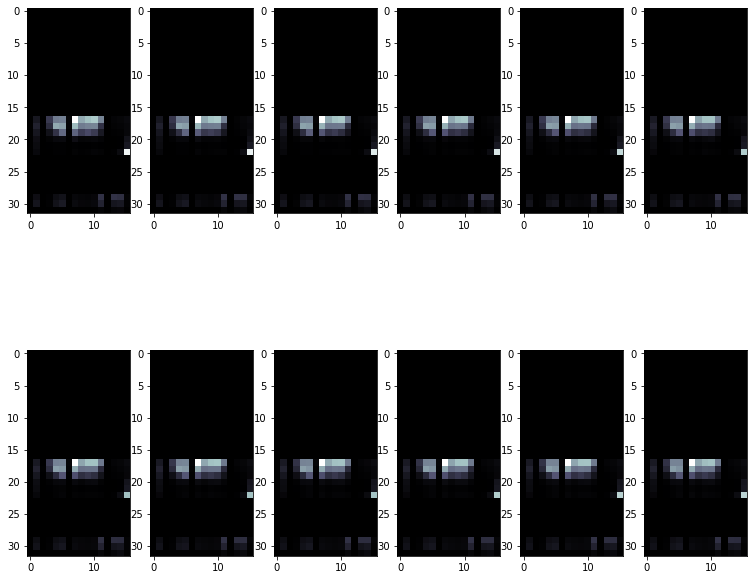

In [5]:
pm_image_cols = [f"sensor_{i}" for i in range(1, 513)]
total_data['pm']
imgs = total_data['pm'][pm_image_cols].to_numpy().reshape(202682, 32, 16)

def plot_gallery(images, titles, h, w, n_row=3, n_col=6, skip=0, step=1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row *2))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[(i * step) + skip],cmap='bone')
    plt.show()
    
plot_gallery(imgs, [i for i  in range(-5,-1)], 32,16,n_row=2, n_col=6, skip=10000, step=1)

### Depth Camera

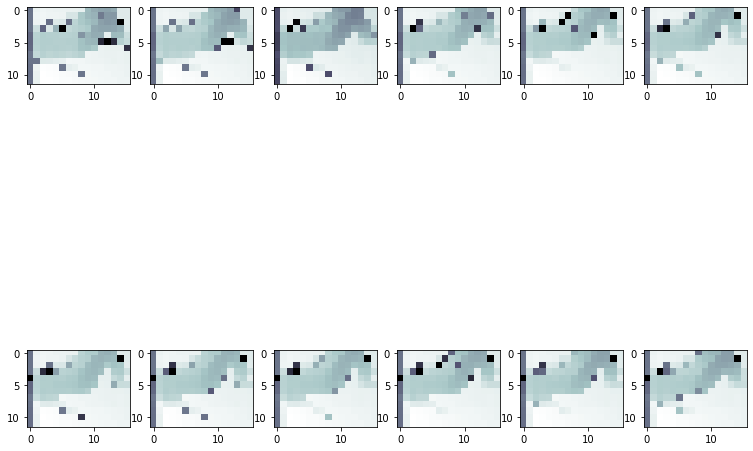

In [6]:
dc_image_cols = [f"sensor_{i}" for i in range(1, 193)]
total_data['dc']
imgs = total_data['dc'][dc_image_cols].to_numpy().reshape(140694 , 12, 16)
plot_gallery(imgs, [i for i  in range(-5,-1)], 32,16,n_row=2, n_col=6, skip=10000, step=1)

### Wrist Accelerometer 

In [7]:
def plot_acc_data(df, subject, action, title=""):
    plt.figure(figsize=(100, 40))
    arr = df.to_numpy()
    arr =  arr[arr[:,5] == action]
    arr =  arr[arr[:,4] == subject]
    plt.plot(range(0,len(arr)),arr[:,1])
    plt.plot(range(0,len(arr)),arr[:,2])
    plt.plot(range(0,len(arr)),arr[:,3])
    plt.title(title,fontsize = 120)
    plt.show()

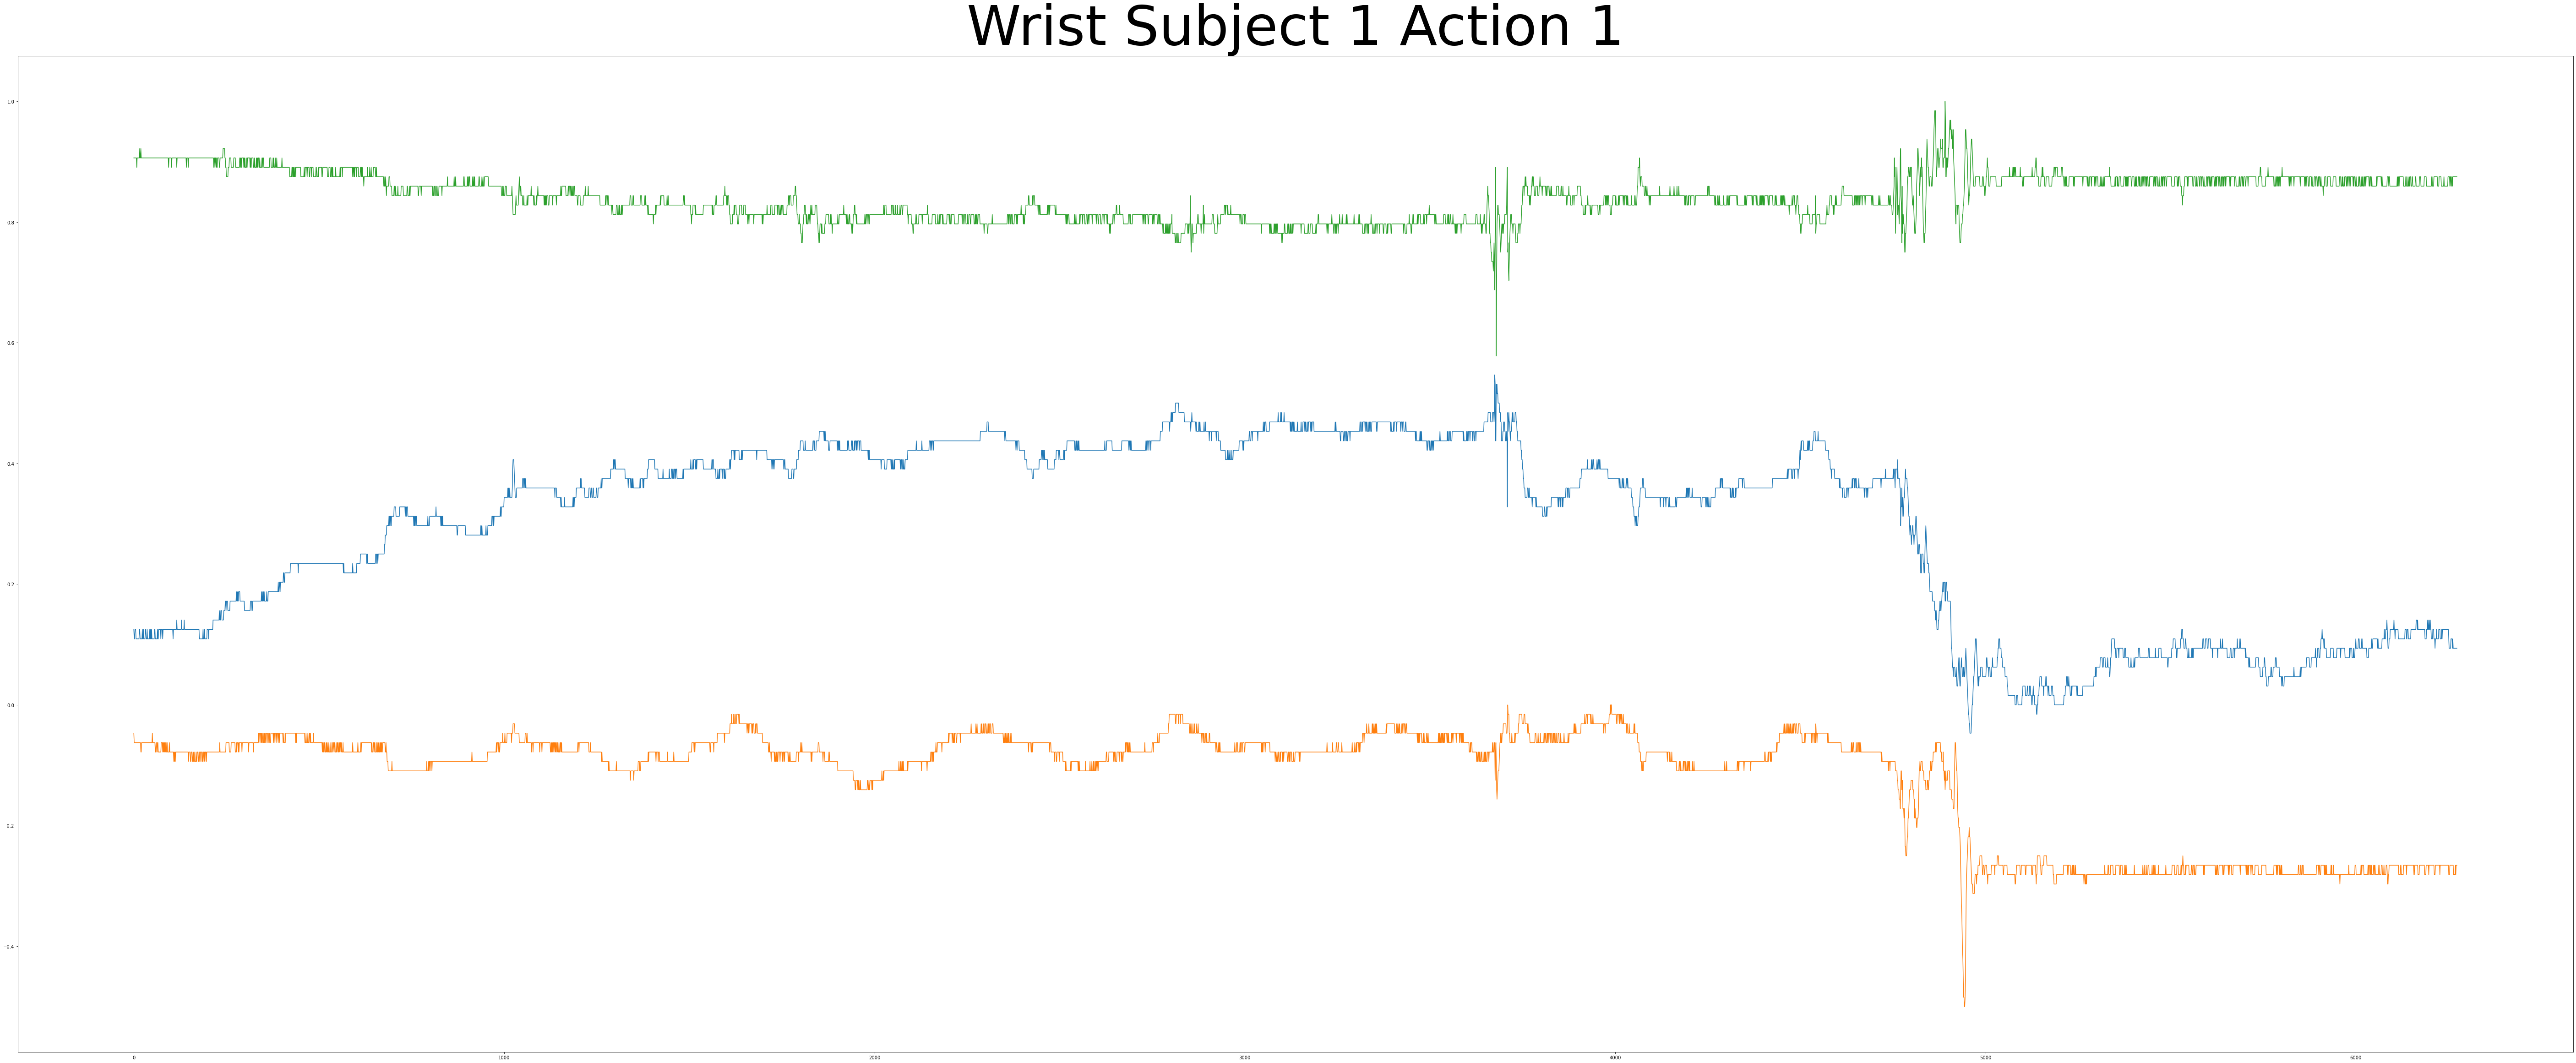

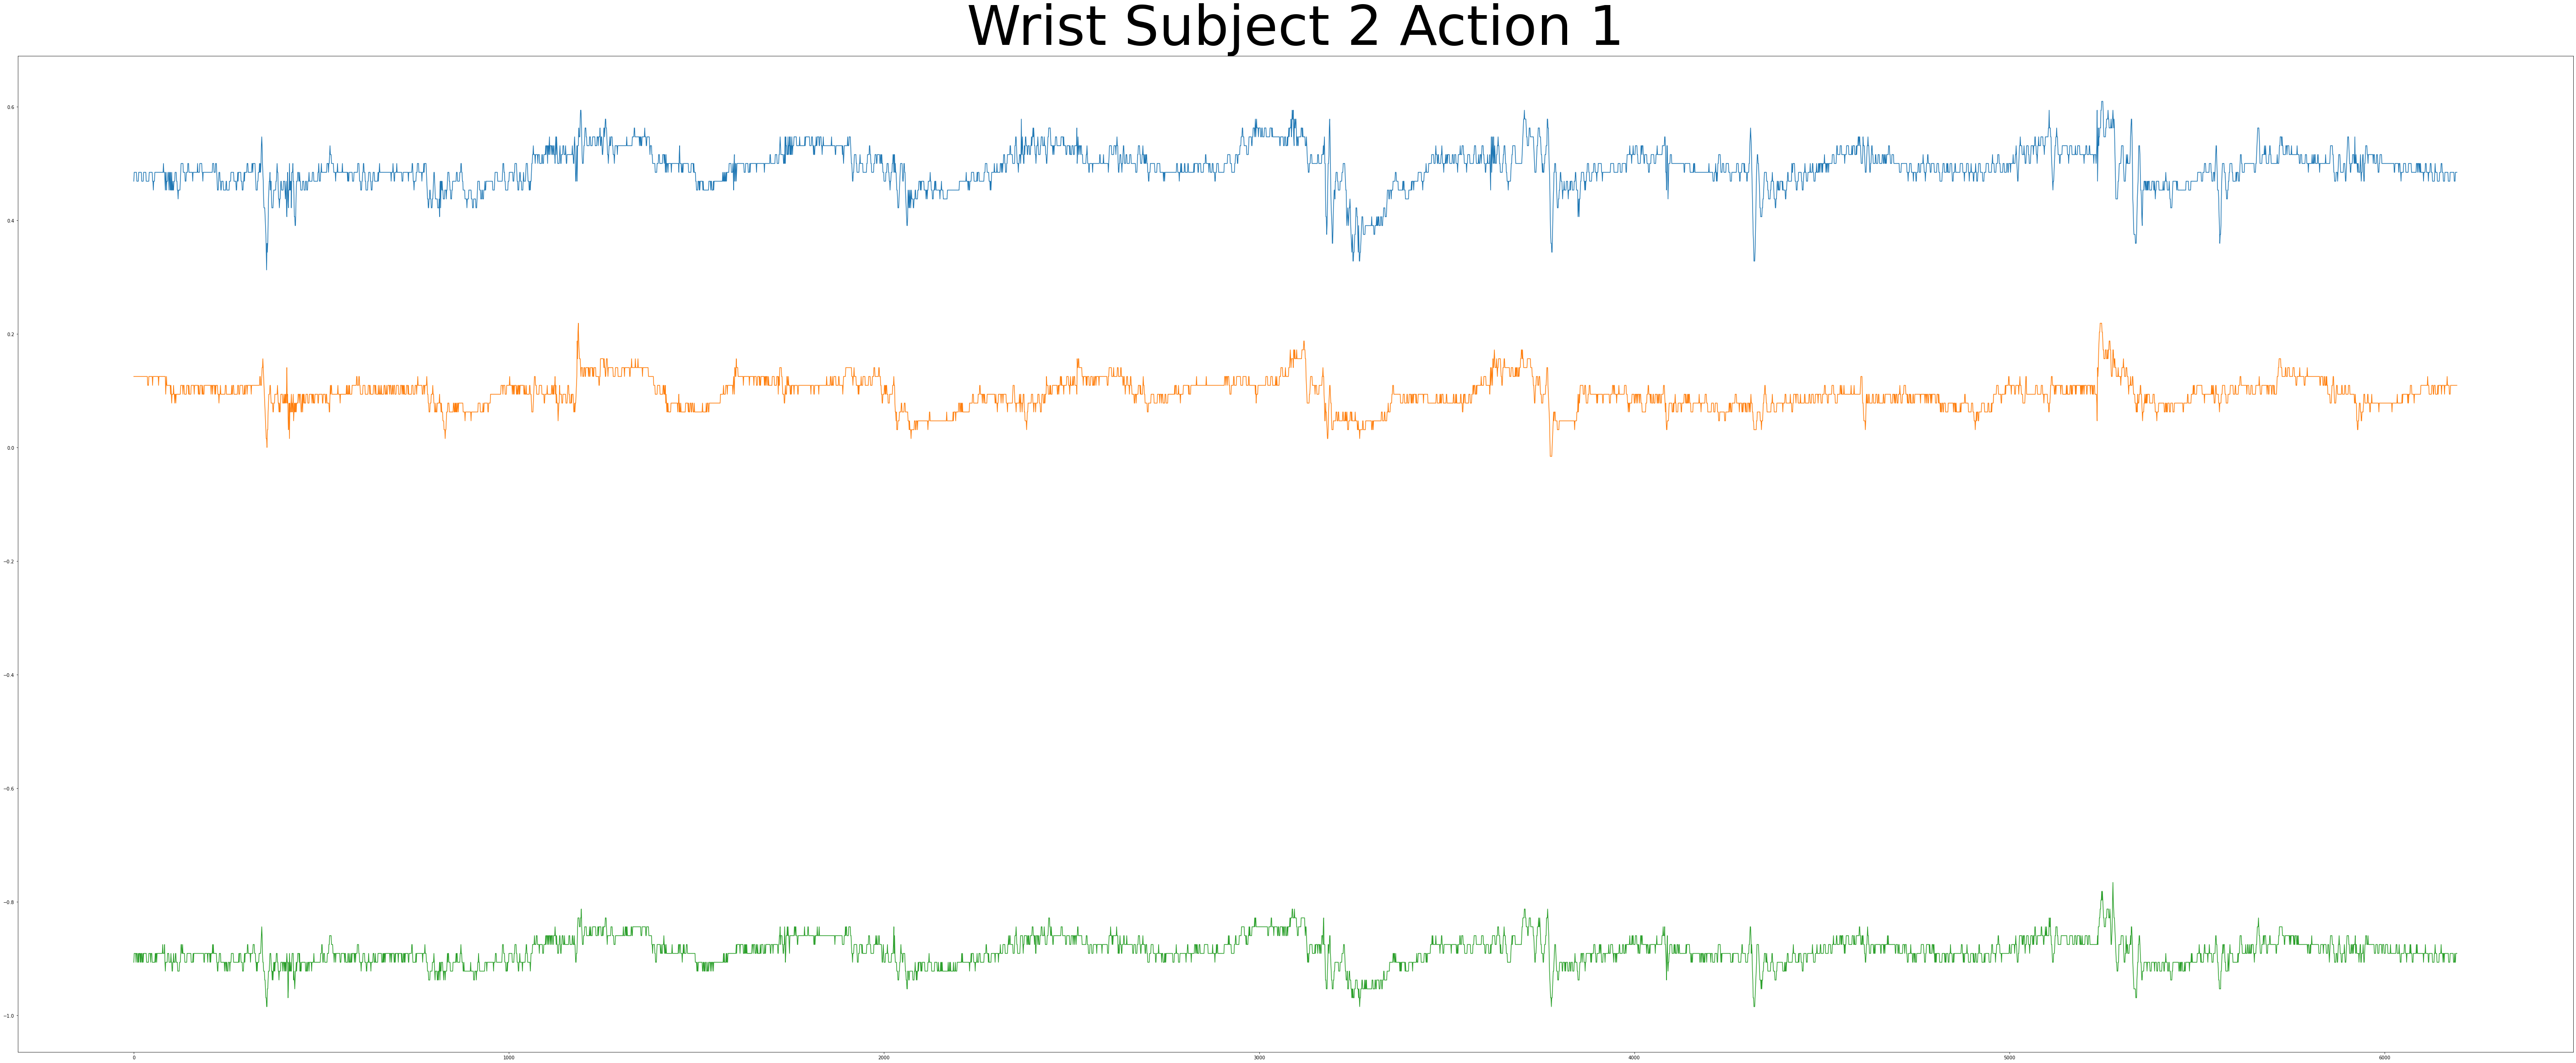

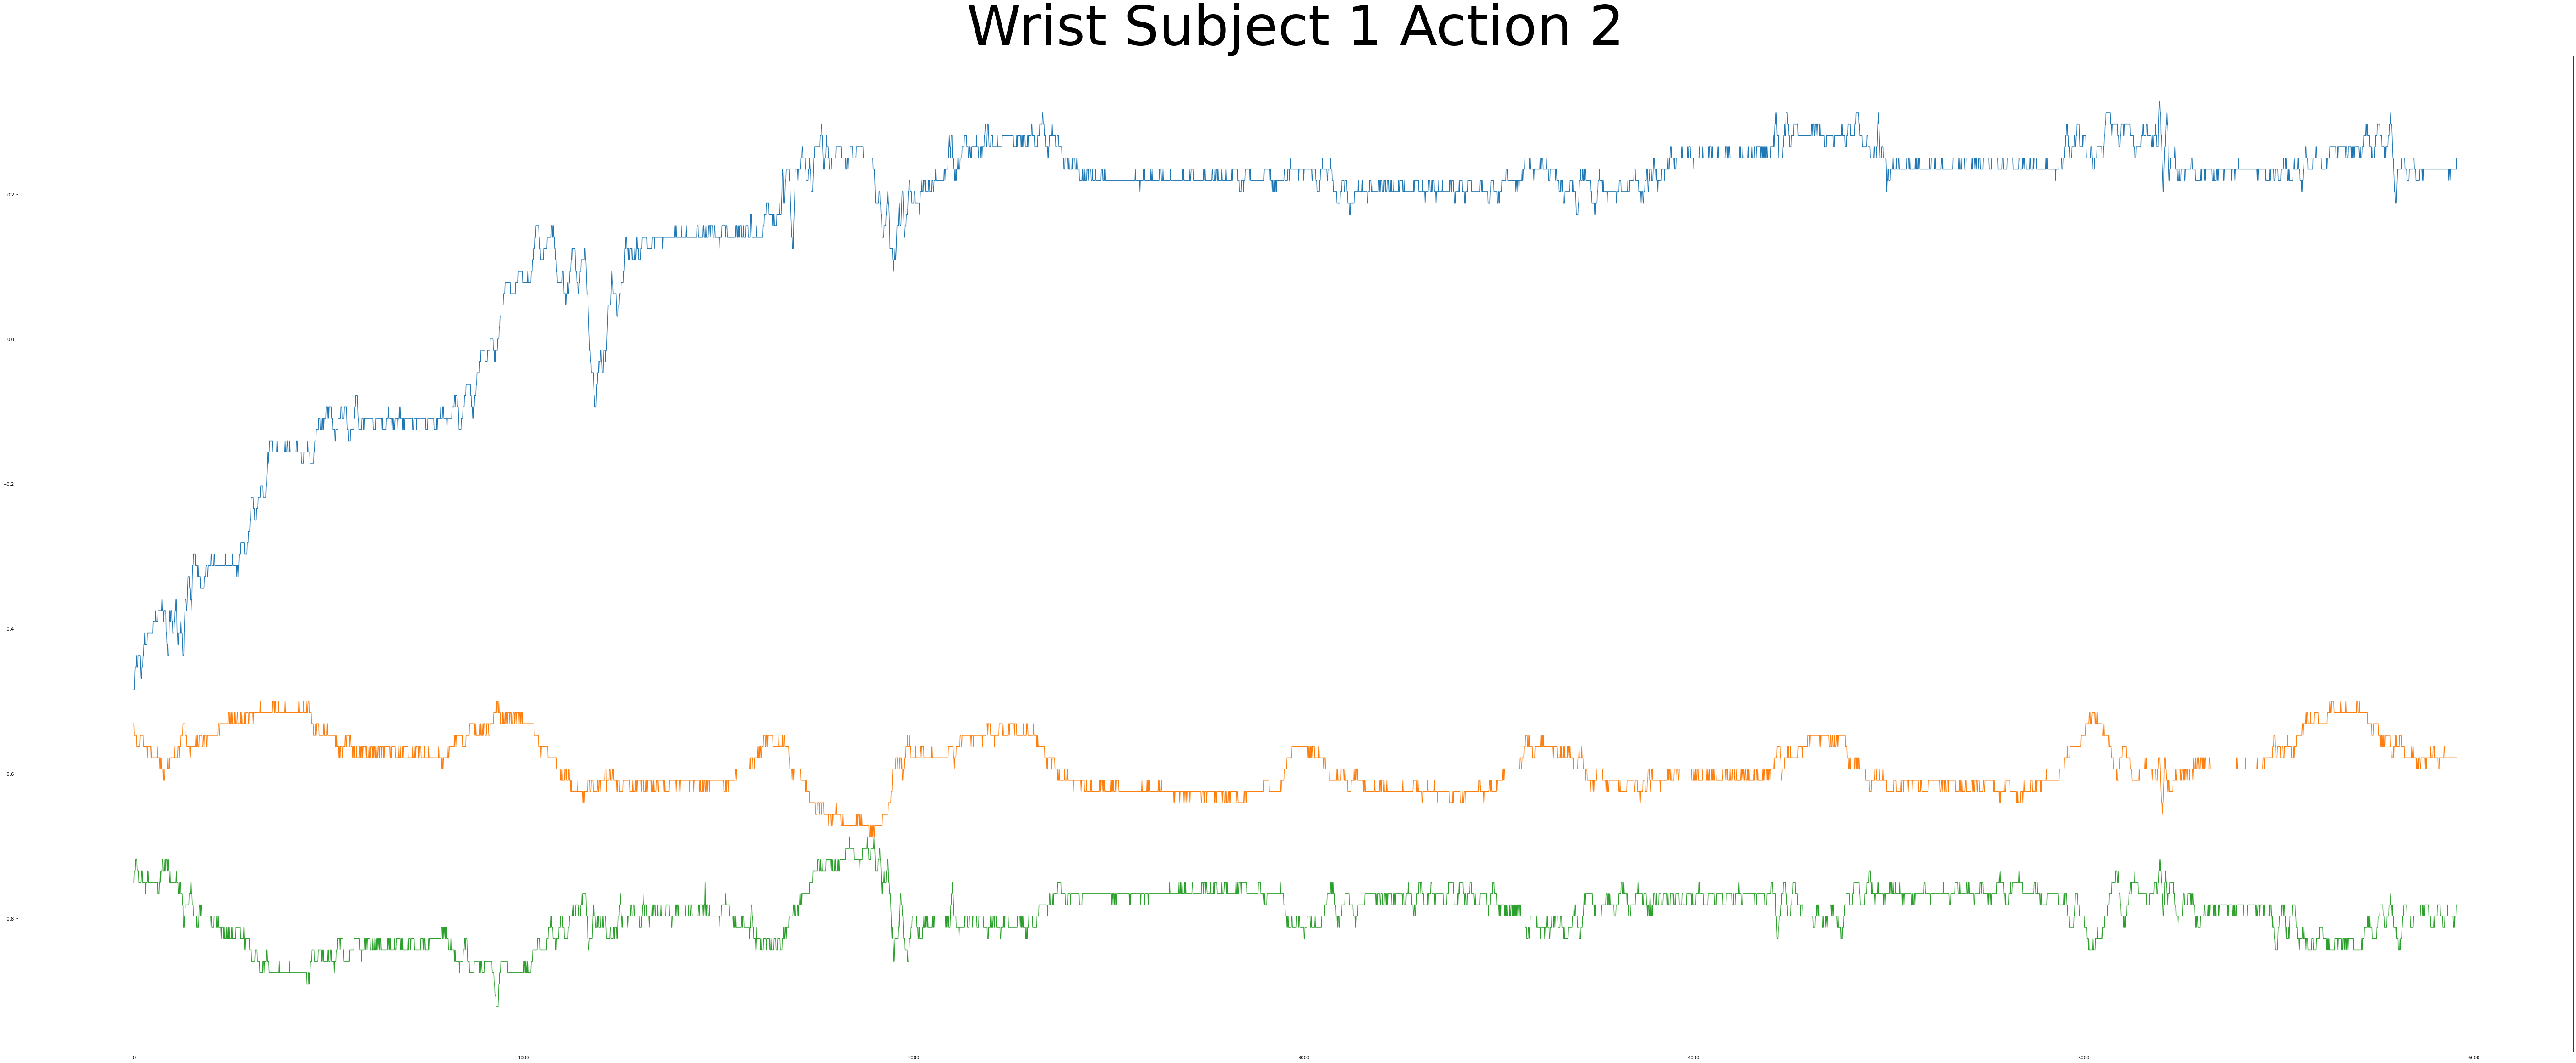

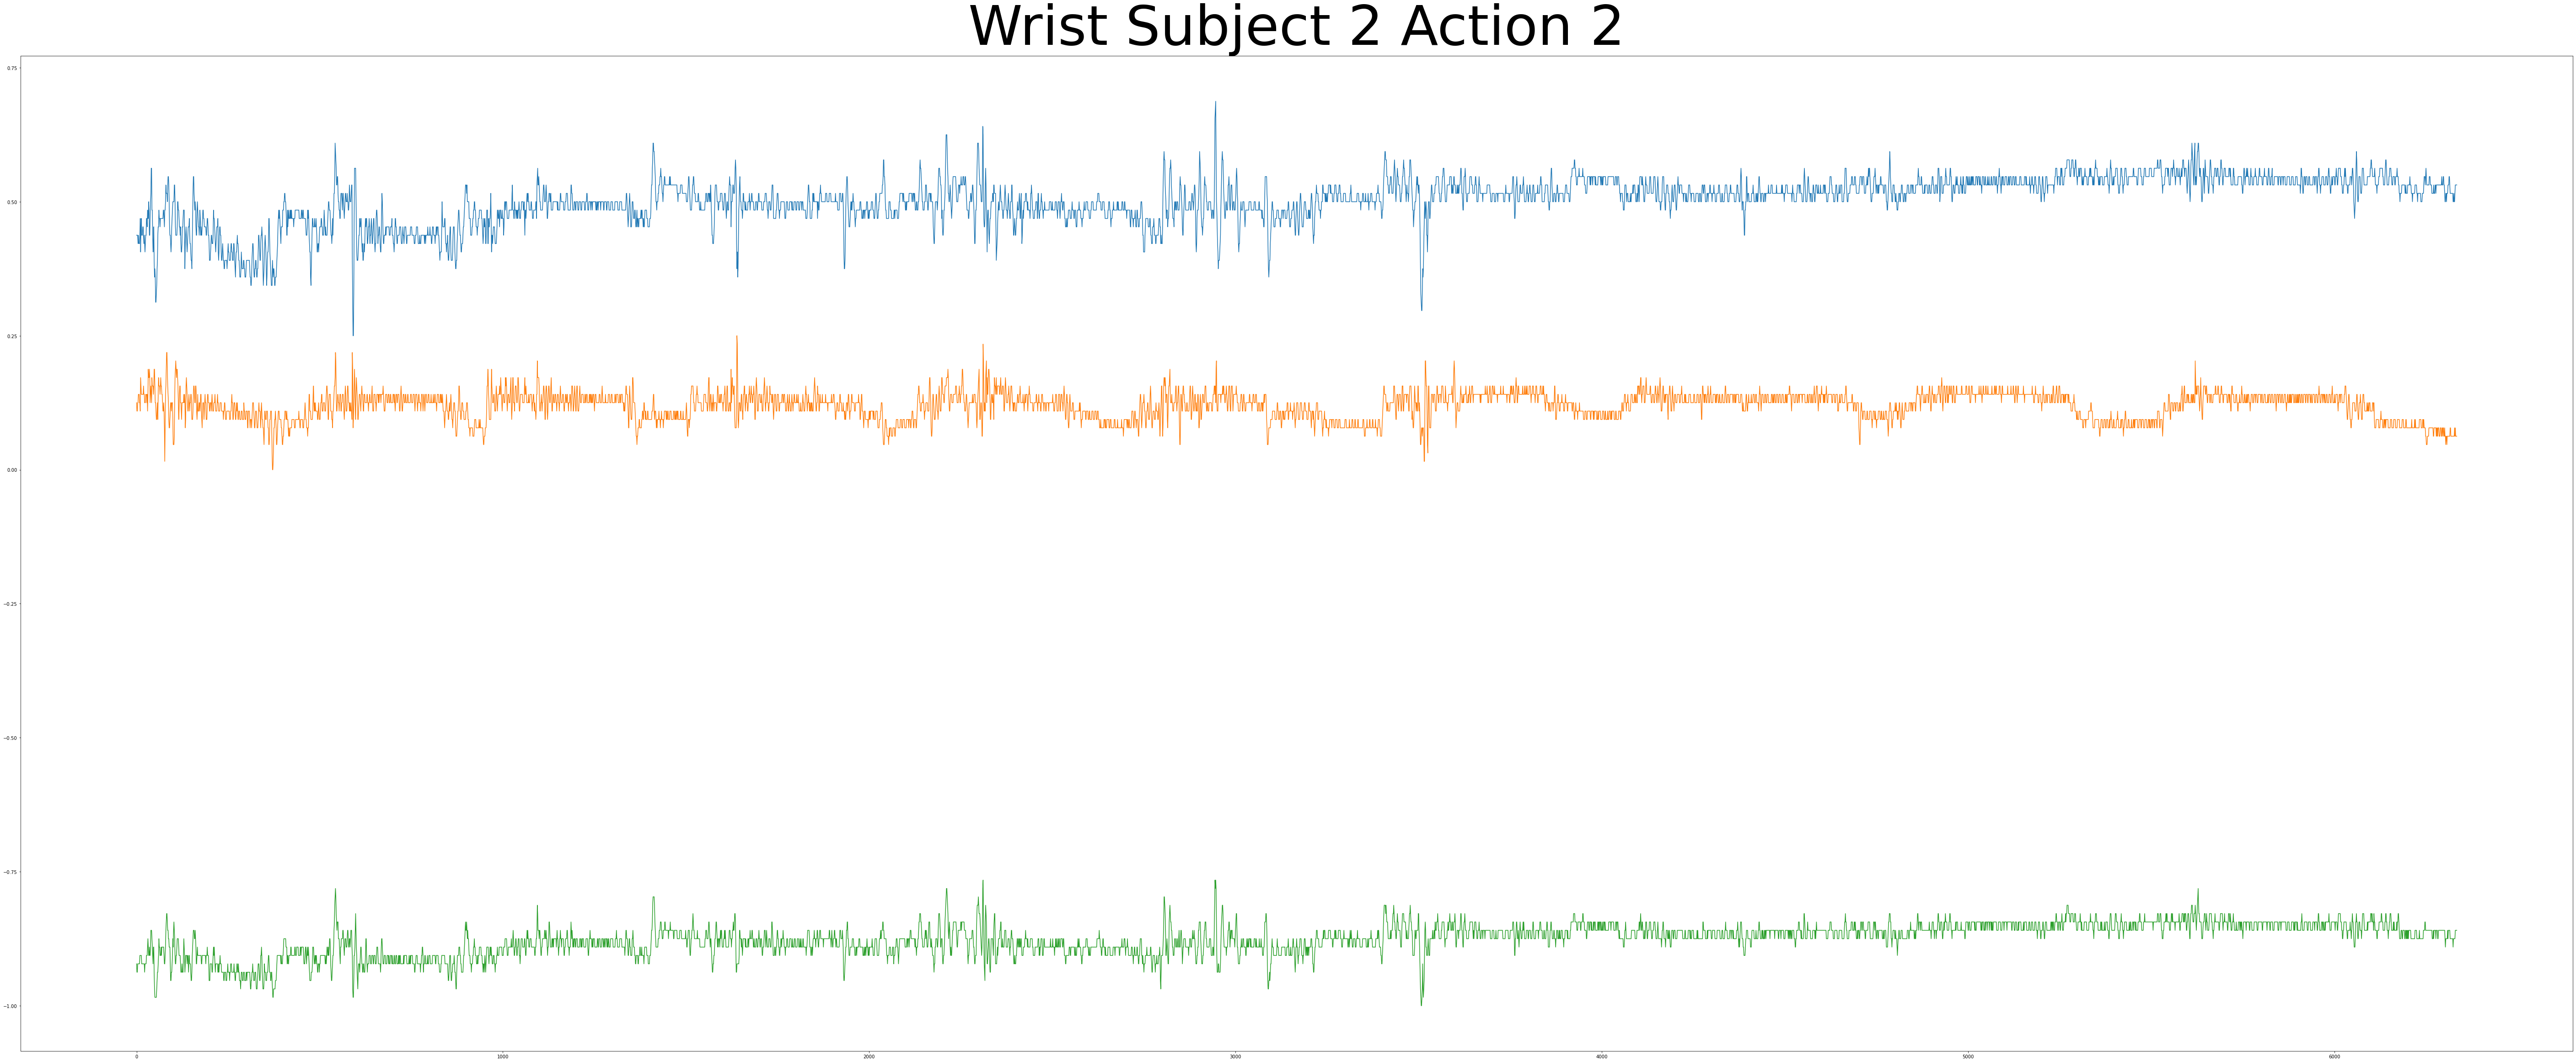

In [8]:
plot_acc_data(total_data['acw'], 1, '1', "Wrist Subject 1 Action 1")
plot_acc_data(total_data['acw'], 2, '1', "Wrist Subject 2 Action 1")
plot_acc_data(total_data['acw'], 1, '2', "Wrist Subject 1 Action 2")
plot_acc_data(total_data['acw'], 2, '2', "Wrist Subject 2 Action 2")

### Thigh Accelerometer 


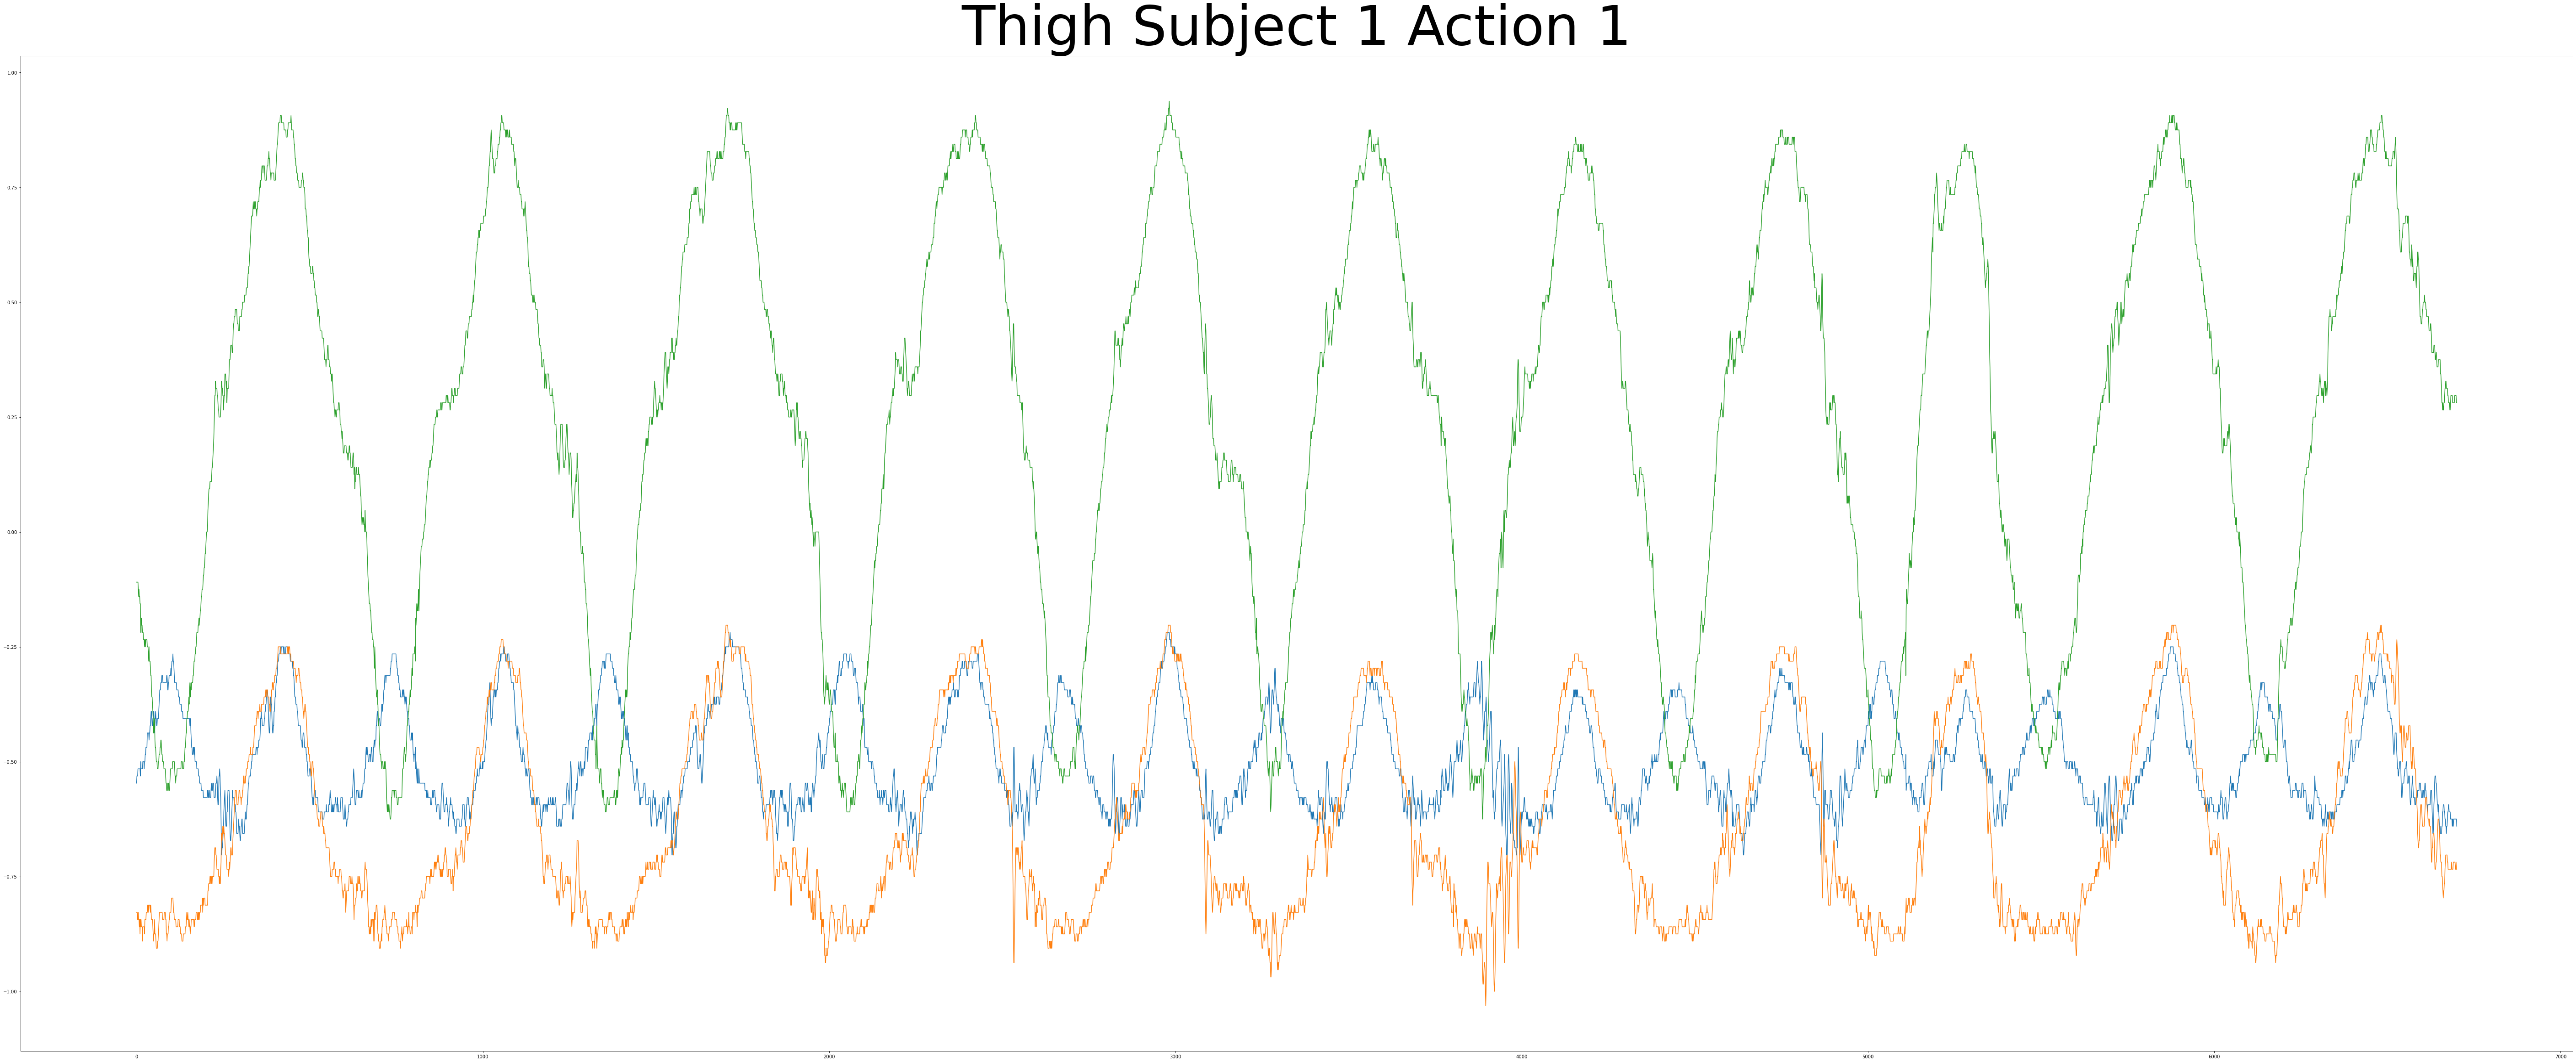

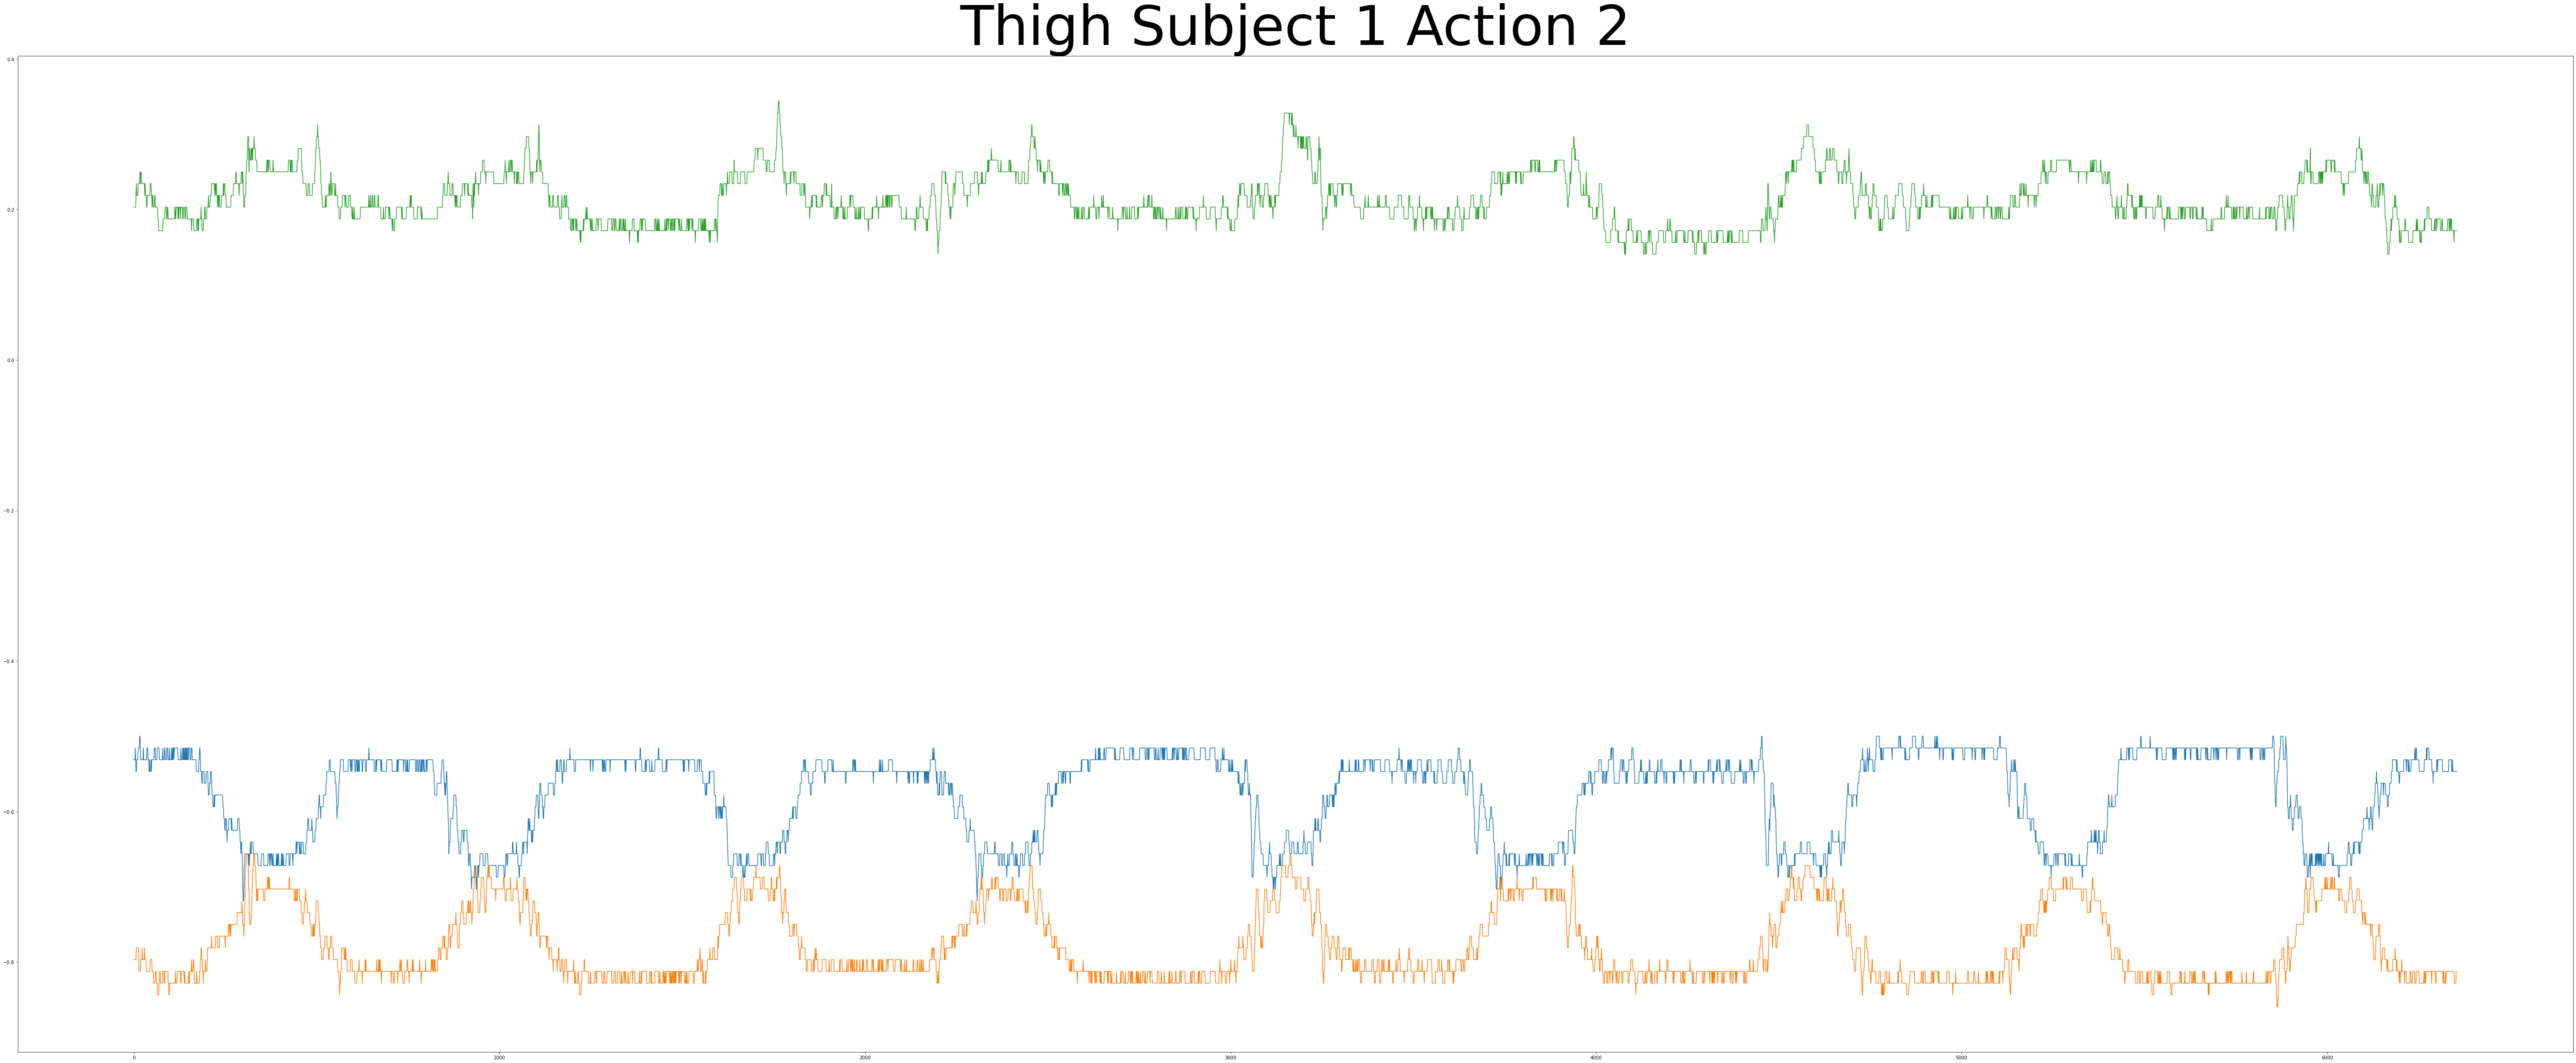

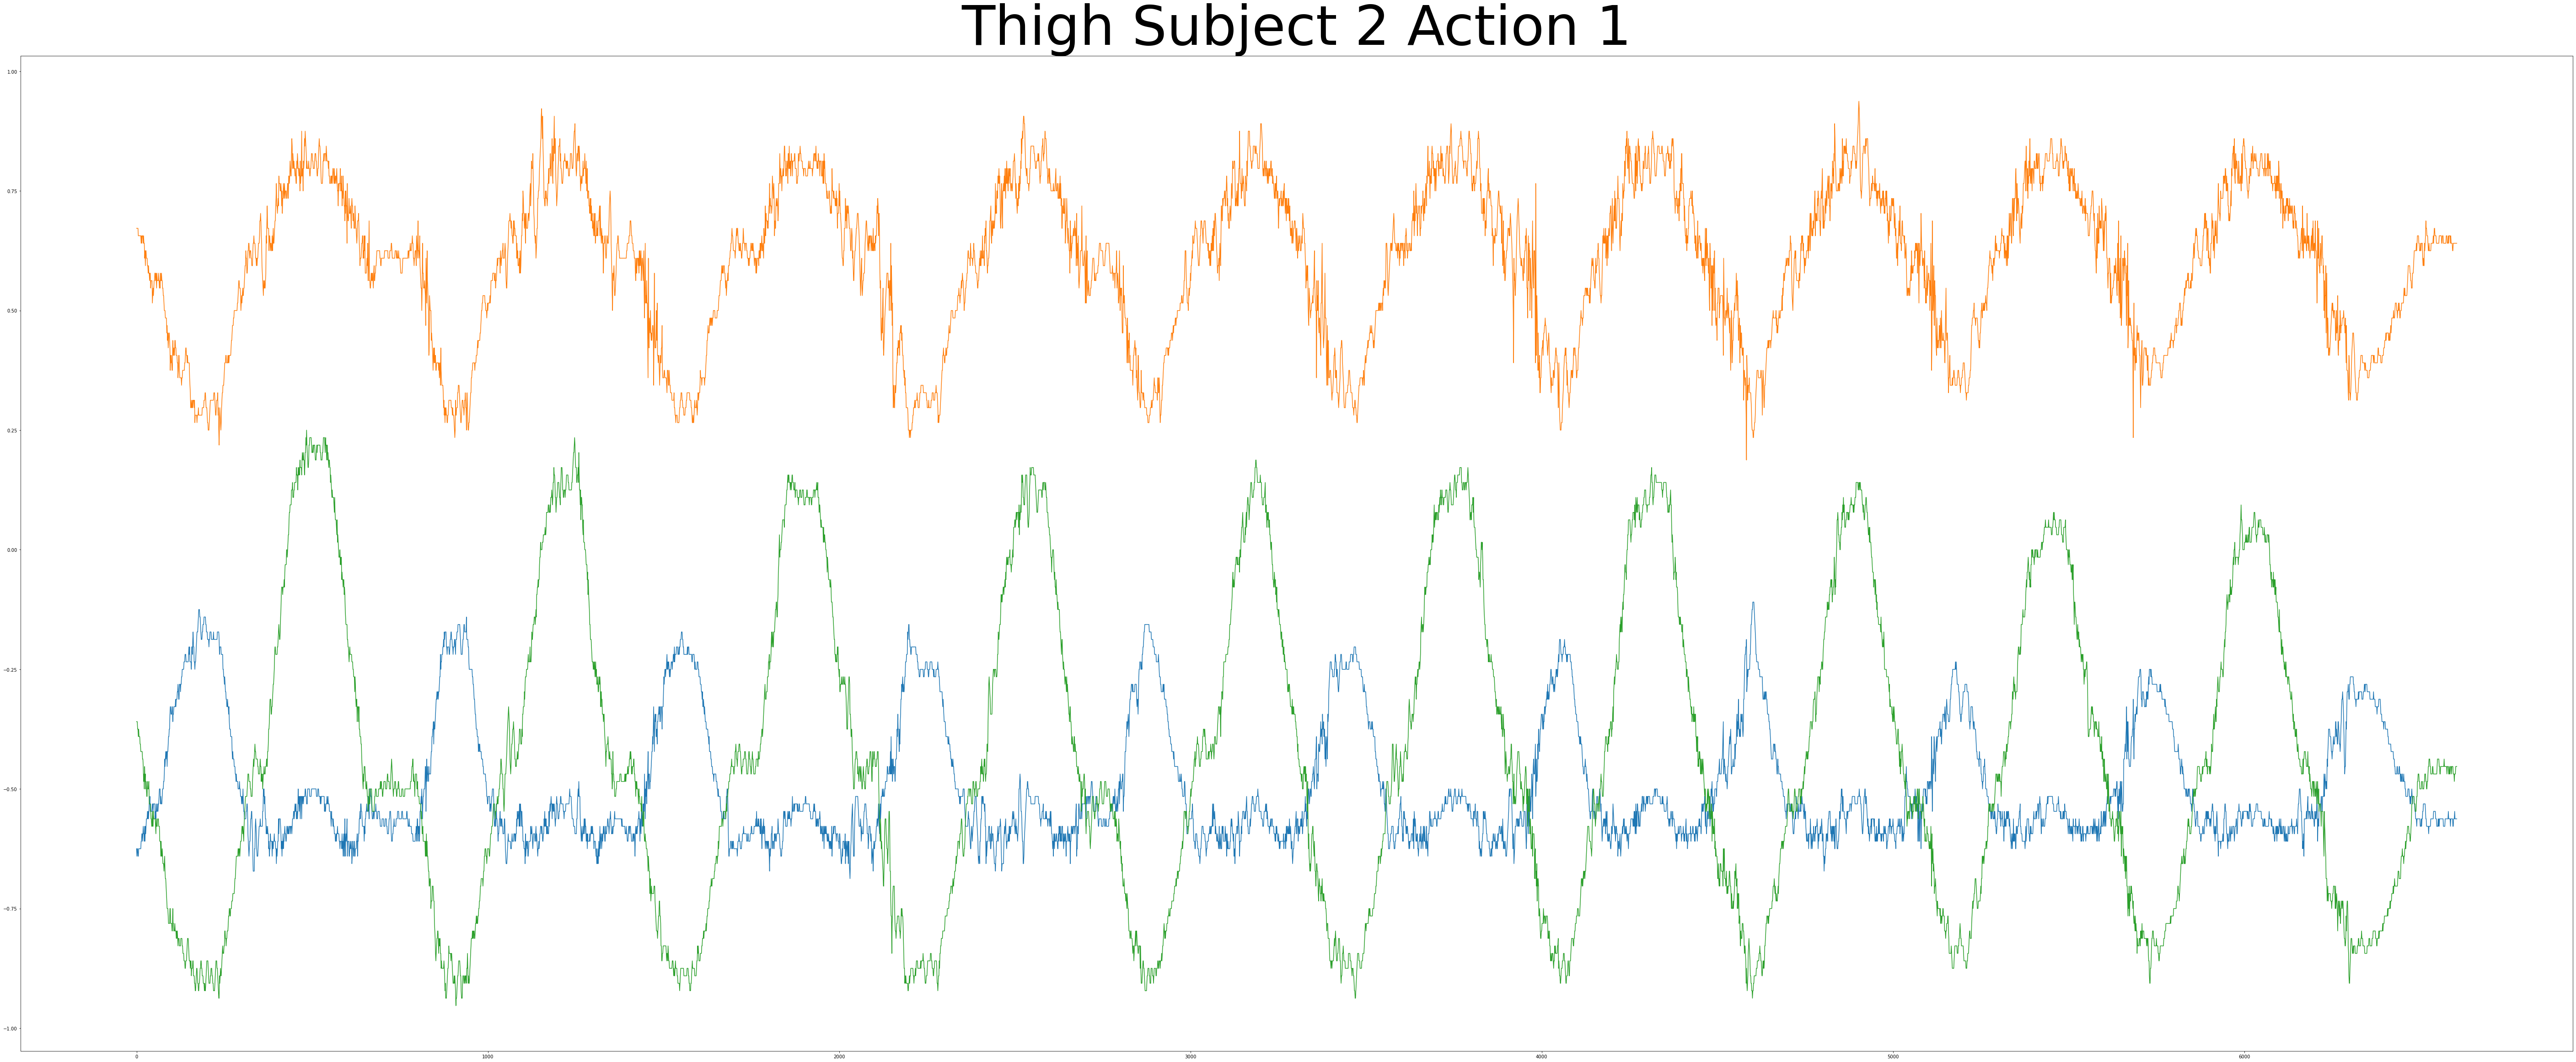

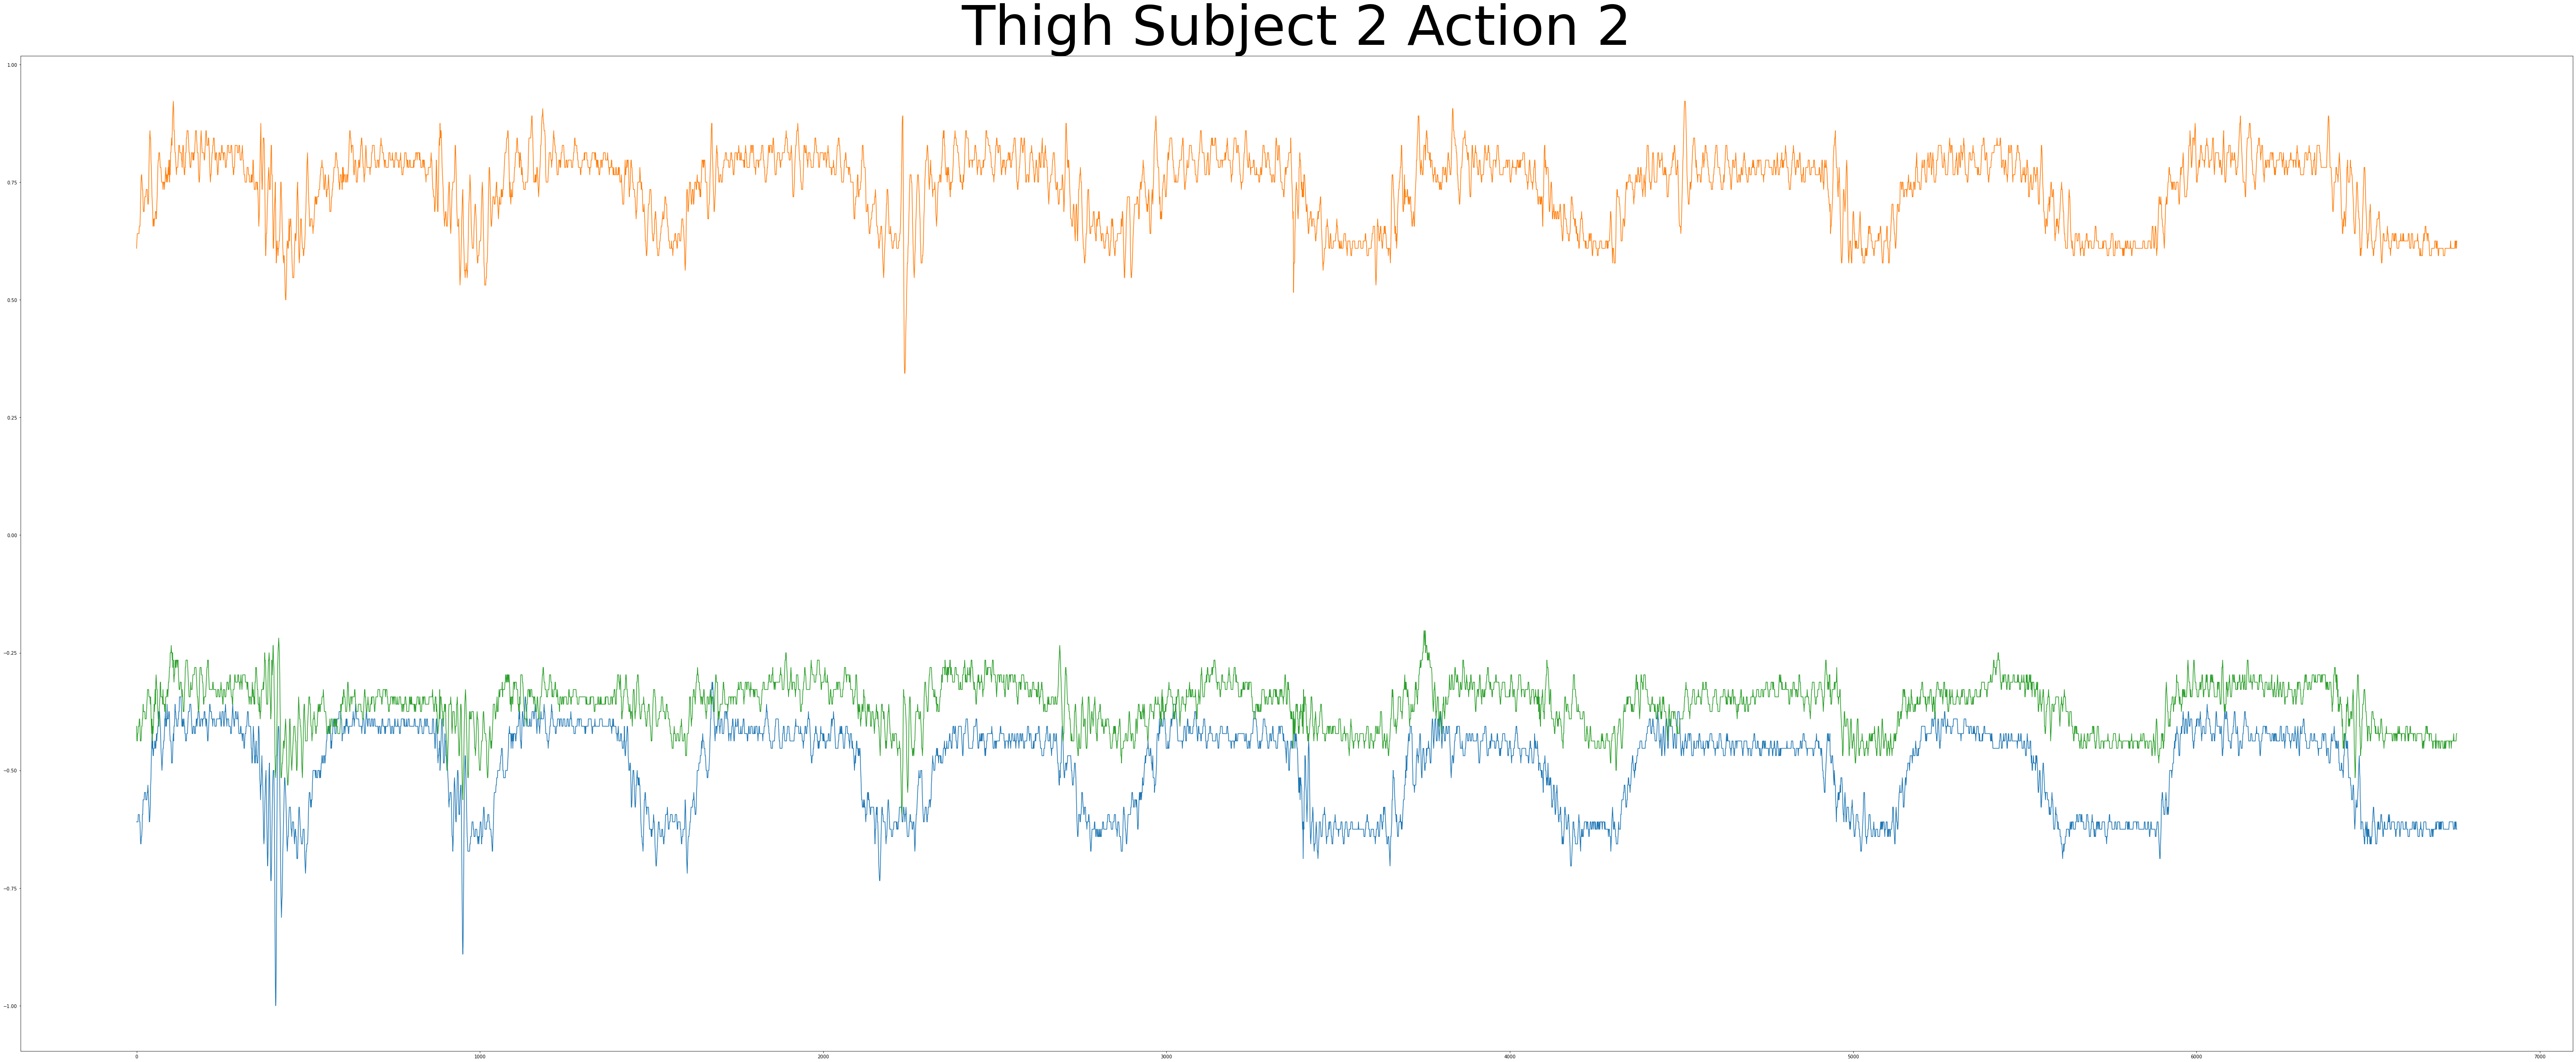

In [9]:
plot_acc_data(total_data['act'], 1, '1', "Thigh Subject 1 Action 1")
plot_acc_data(total_data['act'], 1, '2', "Thigh Subject 1 Action 2")
plot_acc_data(total_data['act'], 2, '1', "Thigh Subject 2 Action 1")
plot_acc_data(total_data['act'], 2, '2', "Thigh Subject 2 Action 2")

## 1.3.3 What is the classification task?
We are going to build models that will take a sampling of the 60 seconds from a subject performing an exercise, and predict what exercise is the subject performing. Since we have 4 different sensors we will treat them each as a different modality. There will be a model that concatenates them all and tries to learn from it, and one that tries to learn from each modality then connects them all together for the classification.
## 1.3.4 Who collected the Data?
Anjana Wijekoon, Nirmalie Wiratunga, Kay Cooper at Robert Gordon University in Aberdeen, UK collected the data for the purpose of exercise recognition, exercise quality assessment and exercise counting. However, we will only perform exercise recognition
## 1.3.5 Evaluation Criteria
TODO

# 2 Sample data and Train test split
We will sample the data into 3 second intervals. We will also save off two of the subjects to see how the models do on subjects they have never see. df_batched will have each row as a 3 second sample

In [10]:
%%time
# take the total dfs and make batches for each action each subject completed
# samples100 is how many samples should be in the 100HZ (the two accleromter data)
# samples15 is how many samples from the images should be take
subjects = range(1,31)
dc_X_cols = [f"sensor_{i}" for i in range(1,193)]
pm_X_cols = [f"sensor_{i}" for i in range(1,513)]
acw_X_cols = ["X", "Y", "Z"]

def batch_data(total_dfs, seconds=5, saved_off=[1,2]):
    samples100 = 100*seconds
    samples15 = 15*seconds
    df_acw = total_dfs['acw']
    df_act = total_dfs['act']
    df_dc = total_dfs['dc']
    df_pm = total_dfs['pm']
    
    all_cols = []
    for i in range(0, samples100):
        all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
    for i in range(0, samples15):
        all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
    for i in range(0, samples15):
        all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
    for i in range(0, samples100):
        all_cols += [f"act_{val}_{i}" for val in acw_X_cols]
    
    
    df_all = pd.DataFrame(columns=all_cols+['action'])
    df_saved = pd.DataFrame(columns=all_cols+['action'])
    
    actions = df_acw['action'].unique()
    pbar_steps = len(actions)*len(subjects)
    pbar = tqdm(desc="batch data", total=pbar_steps)
    
    for subject in subjects:
        actions = df_acw['action'].unique()
        for action in actions:
            X_acw = df_acw[(df_acw.subject == subject) & (df_acw.action == action)][acw_X_cols].to_numpy()
            X_acw = X_acw[range(0, (X_acw.shape[0]//samples100)*samples100)] # cut off records that don't fit in the window
            X_acw = np.reshape(X_acw, (X_acw.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            X_dc = df_dc[(df_dc.subject == subject) & (df_dc.action == action)][dc_X_cols].to_numpy()
            X_dc = X_dc[range(0, (X_dc.shape[0]//samples15)*samples15)]
            X_dc = np.reshape(X_dc, (X_dc.shape[0]//samples15, samples15*len(dc_X_cols)))
            
            X_pm = df_pm[(df_pm.subject == subject) & (df_pm.action == action)][pm_X_cols].to_numpy()
            X_pm = X_pm[range(0, (X_pm.shape[0]//samples15)*samples15)]
            X_pm = np.reshape(X_pm, (X_pm.shape[0]//samples15, samples15*len(pm_X_cols)))
            
            X_act = df_act[(df_act.subject == subject) & (df_act.action == action)][acw_X_cols].to_numpy()
            X_act = X_act[range(0, (X_act.shape[0]//samples100)*samples100)]
            X_act = np.reshape(X_act, (X_act.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            # trim to the smallest one of these 4
            num_records = min(X_acw.shape[0], X_act.shape[0], X_pm.shape[0], X_dc.shape[0])
            X_acw = X_acw[range(0,num_records)]
            X_dc = X_dc[range(0,num_records)]
            X_pm = X_pm[range(0,num_records)]
            X_act = X_act[range(0,num_records)]
            
            X_total = np.hstack((X_acw, X_dc, X_pm, X_act))
            
            df_tmp = pd.DataFrame(X_total, columns=all_cols)
            df_tmp['action'] = action
            if subject in saved_off:
                df_saved = pd.concat([df_saved, df_tmp])
            else:
                df_all = pd.concat([df_all, df_tmp])
            
            pbar.update(1)
            
    return (df_all, df_saved)

df_batched, df_batch_saved_off = batch_data(total_data, seconds=3)
df_batched.head()

batch data:   0%|          | 0/240 [00:00<?, ?it/s]

Wall time: 1min 5s


acw_X_0   acw_Y_0   acw_Z_0   acw_X_1   acw_Y_1   acw_Z_1   acw_X_2  \
0 -0.656250 -0.078125  0.687500 -0.656250 -0.078125  0.687500 -0.656250   
1 -0.437500 -0.062500  0.812500 -0.453125 -0.062500  0.812500 -0.453125   
2 -0.687500  0.015625  0.671875 -0.703125  0.015625  0.671875 -0.687500   
3 -0.625000  0.000000  0.718750 -0.625000  0.000000  0.718750 -0.640625   
4 -0.578125  0.046875  0.750000 -0.578125  0.046875  0.750000 -0.578125   

    acw_Y_2  acw_Z_2   acw_X_3  ...  act_X_297  act_Y_297  act_Z_297  \
0 -0.078125  0.68750 -0.656250  ...  -0.750000   0.640625  -0.125000   
1 -0.062500  0.81250 -0.453125  ...  -0.703125   0.484375  -0.468750   
2  0.015625  0.65625 -0.687500  ...  -0.703125   0.484375  -0.421875   
3  0.000000  0.71875 -0.640625  ...  -0.687500   0.593750  -0.203125   
4  0.046875  0.75000 -0.562500  ...  -0.296875   0.109375  -0.890625   

   act_X_298  act_Y_298  act_Z_298  act_X_299  act_Y_299  act_Z_299  action  
0  -0.750000   0.625000  -0.140625  -0.750000   0.625000  -0.140625       1  
1  -0.703125   0.468750  -0.468750  -0.703125   0.468750  -0.453125       1  
2  -0.718750   0.484375  -0.421875  -0.718750   0.453125  -0.437500       1  
3  -0.687500   0.609375  -0.203125  -0.703125   0.609375  -0.187500       1  
4  -0.265625   0.203125  -0.953125  -0.265625   0.109375  -0.921875       1  

[5 rows x 33481 columns]

In [11]:
df_batch_saved_off.head()

acw_X_0   acw_Y_0   acw_Z_0   acw_X_1   acw_Y_1   acw_Z_1   acw_X_2  \
0  0.125000 -0.046875  0.906250  0.109375 -0.062500  0.906250  0.109375   
1  0.156250 -0.062500  0.906250  0.156250 -0.062500  0.890625  0.156250   
2  0.218750 -0.078125  0.890625  0.218750 -0.078125  0.875000  0.234375   
3  0.281250 -0.093750  0.859375  0.281250 -0.093750  0.875000  0.281250   
4  0.359375 -0.062500  0.843750  0.359375 -0.062500  0.843750  0.359375   

    acw_Y_2   acw_Z_2   acw_X_3  ...  act_X_297  act_Y_297  act_Z_297  \
0 -0.062500  0.906250  0.125000  ...  -0.640625  -0.562500   0.437500   
1 -0.062500  0.890625  0.156250  ...  -0.625000  -0.796875   0.171875   
2 -0.078125  0.890625  0.234375  ...  -0.593750  -0.750000   0.281250   
3 -0.093750  0.859375  0.281250  ...  -0.593750  -0.734375   0.296875   
4 -0.078125  0.843750  0.359375  ...  -0.593750  -0.734375   0.312500   

   act_X_298  act_Y_298  act_Z_298  act_X_299  act_Y_299  act_Z_299  action  
0  -0.656250  -0.562500   0.468750  -0.671875  -0.578125   0.468750       1  
1  -0.625000  -0.781250   0.171875  -0.625000  -0.781250   0.171875       1  
2  -0.609375  -0.750000   0.296875  -0.609375  -0.750000   0.296875       1  
3  -0.593750  -0.734375   0.296875  -0.593750  -0.734375   0.296875       1  
4  -0.578125  -0.734375   0.312500  -0.593750  -0.734375   0.296875       1  

[5 rows x 33481 columns]

## Split into Train/Test for tuning

In [12]:
seconds = 3
samples100 = 100*seconds
samples15 = 15*seconds

all_cols = []
for i in range(0, samples100):
    all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
for i in range(0, samples15):
    all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
for i in range(0, samples15):
    all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
for i in range(0, samples100):
    all_cols += [f"act_{val}_{i}" for val in acw_X_cols]

In [13]:
X = df_batched[all_cols].to_numpy()
X.shape

(2796, 33480)

In [14]:
df_y = pd.get_dummies(df_batched.action, prefix='action_ohe')
y = df_y.to_numpy()
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 3 General Model

In [16]:
from tensorflow.keras.layers import Dense, Activation, Input, GRU, SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

def get_combined_model():
    input_all = Input(shape=(X.shape[1],))
    x = Dense(units=2048, activation='sigmoid',kernel_initializer='random_normal')(input_all)
    x = Dense(units=1024, activation='sigmoid',kernel_initializer='random_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='sigmoid',kernel_initializer='random_normal')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512, activation='tanh',kernel_initializer='random_normal')(x)
    prediction = Dense(units=8, activation='softmax')(x)

    model = Model(inputs=input_all, outputs=prediction)
    return model

In [17]:
from tensorflow.keras.optimizers import Adam
model = get_combined_model()
model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33480)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              68569088  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656

In [18]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=200,  batch_size=10, verbose=False)

Wall time: 10min 9s


## Results:
We are slightly over trained. We will step back on epochs for the KFolded models

In [19]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

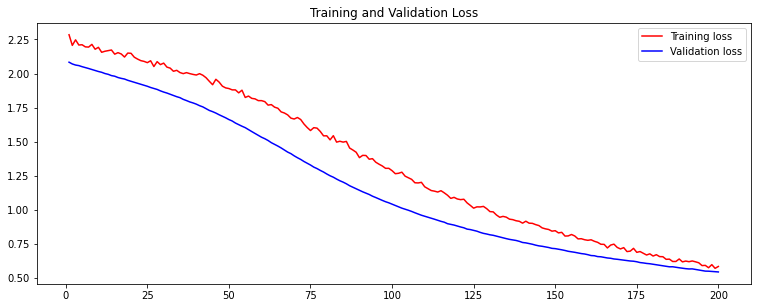

Train: 89.08765652951699
Validation: 79.82142857142858
Unseen: 65.55023923444976


In [20]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plot_history(history)

yhat = model.predict(X_train)
yhat = np.argmax(yhat, axis=1)
y_train_actual = np.argmax(y_train, axis=1)
print('Train:', accuracy_score(y_train_actual, yhat)*100)

yhat = model.predict(X_test)
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

X_unseen = df_batch_saved_off[all_cols].to_numpy()
df_y_unseen = pd.get_dummies(df_batch_saved_off.action, prefix='action_ohe')
y_unseen = df_y_unseen.to_numpy()

yhat = model.predict(X_unseen)
yhat = np.argmax(yhat, axis=1)
y_unseen_actual = np.argmax(y_unseen, axis=1)
print('Unseen:', accuracy_score(y_unseen_actual, yhat)*100)
    

## K Fold this tuned model to get results

Fold 0
Train: 88.22126847877921
Validation: 79.25608011444922
Unseen: 70.81339712918661


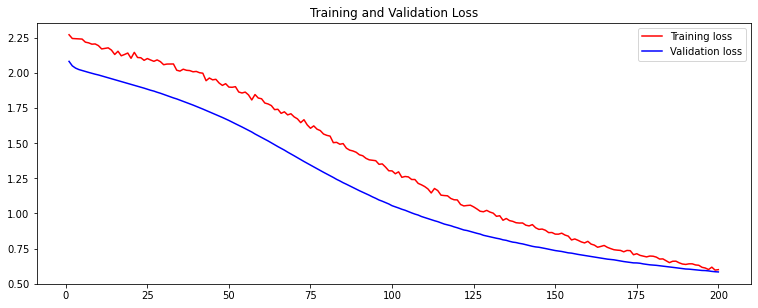

Fold 1
Train: 88.88888888888889
Validation: 78.2546494992847
Unseen: 64.11483253588517


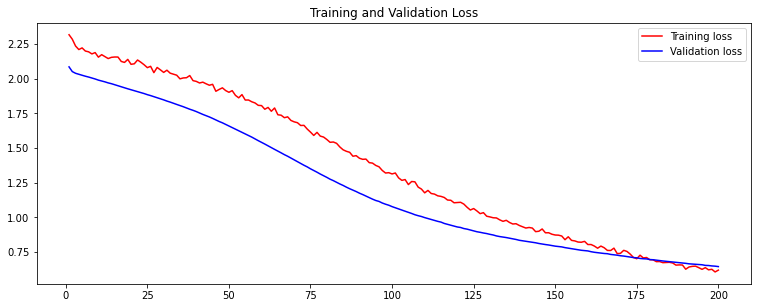

Fold 2
Train: 88.22126847877921
Validation: 78.54077253218884
Unseen: 67.46411483253588


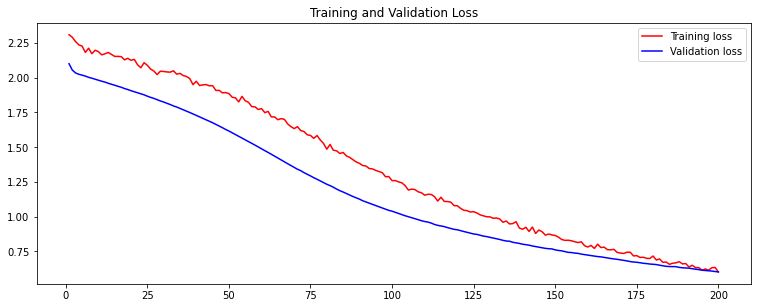

Fold 3
Train: 88.36432999523129
Validation: 78.39771101573677
Unseen: 64.11483253588517


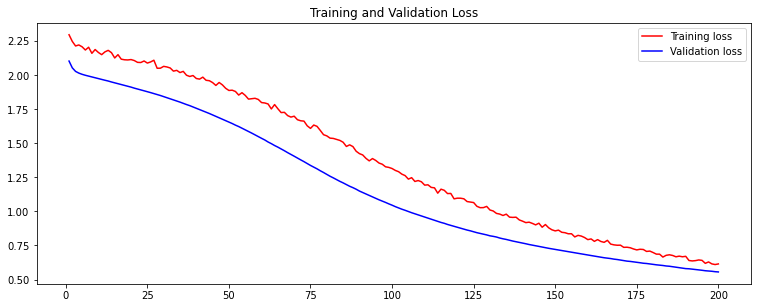

Wall time: 38min 41s


In [21]:
%%time
folds = StratifiedKFold(n_splits=4, shuffle=True)
y_actual = np.argmax(y, axis=1)
total_model_metrics = []
for index, (train_indices, val_indices) in enumerate(folds.split(X, y_actual)):
    model = get_combined_model()
    # TODO: move this to the model def.
    model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X[train_indices], y[train_indices],
                        validation_data=(X[val_indices], y[val_indices]),
                        epochs=200,  batch_size=10, verbose=False)
    yhat = model.predict(X[train_indices])
    yhat = np.argmax(yhat, axis=1)
    y_train_actual = np.argmax(y[train_indices], axis=1)
    print(f"Fold {index}")
    acc_train = accuracy_score(y_train_actual, yhat)*100
    print('Train:', acc_train)

    yhat = model.predict(X[val_indices])
    yhat = np.argmax(yhat, axis=1)
    y_test_actual = np.argmax(y[val_indices], axis=1)
    acc_test = accuracy_score(y_test_actual, yhat)*100
    print('Validation:', acc_test)
    
    
    yhat = model.predict(X_unseen)
    yhat = np.argmax(yhat, axis=1)
    y_unseen_actual = np.argmax(y_unseen, axis=1)
    acc_unseen = accuracy_score(y_unseen_actual, yhat)*100
    print('Unseen:', acc_unseen)
    total_model_metrics.append((history, acc_train, acc_test, acc_unseen))
    plot_history(history)

## Lets look how we do at unseen subjects

In [52]:
X_unseen = df_batch_saved_off[all_cols].to_numpy()
df_y_unseen = pd.get_dummies(df_batch_saved_off.action, prefix='action_ohe')
y_unseen = df_y_unseen.to_numpy()

yhat = model.predict(X_unseen)
yhat = np.argmax(yhat, axis=1)
y_unseen_actual = np.argmax(y_unseen, axis=1)
print('Train:', accuracy_score(y_unseen_actual, yhat)*100)


Train: 67.46411483253588


This is not a great result, but also not too surprising, we will see if more sophisticated models do better on unseen subjects

# 4 Multi Modal Model

## Split data into its modalities

In [29]:
# we have 300 different x,y,z's for each acc

#wrist data
acw_X_cols_batched = []
for j in range(0, samples100):
    acw_X_cols_batched += [f"acw_{val}_{j}" for val in acw_X_cols]
X_acw_batched = df_batched[acw_X_cols_batched].to_numpy()

# thigh data
act_X_cols_batched = []
for j in range(0, samples100):
    act_X_cols_batched += [f"act_{val}_{j}" for val in acw_X_cols]
X_act_batched = df_batched[acw_X_cols_batched].to_numpy()

# Depth Camera data
dc_X_cols_batched = []
for j in range(0, samples15):
    dc_X_cols_batched += [f"dc_{val}_{j}" for val in dc_X_cols]
X_dc_batched = df_batched[dc_X_cols_batched].to_numpy()
    
# Pressure Mat data
pm_X_cols_batched = []
for j in range(0, samples15):
    pm_X_cols_batched += [f"pm_{val}_{j}" for val in pm_X_cols]
X_pm_batched = df_batched[pm_X_cols_batched].to_numpy()
len(pm_X_cols_batched)

23040

In [30]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_act_batched_train, X_act_batched_test, \
X_acw_batched_train, X_acw_batched_test, \
X_dc_batched_train, X_dc_batched_test, \
X_pm_batched_train, X_pm_batched_test, \
y_train, y_test = \
train_test_split(X_act_batched, X_acw_batched, X_dc_batched, X_pm_batched, y, 
                 test_size=0.2, shuffle=True)

print(X_act_batched_train.shape)
print(X_act_batched_test.shape)
print(X_acw_batched_train.shape)
print(X_acw_batched_test.shape)
print(X_dc_batched_train.shape)
print(X_dc_batched_test.shape)
print(X_pm_batched_train.shape)
print(X_pm_batched_test.shape)
print(y_train.shape)
print(y_test.shape)

(2236, 900)
(560, 900)
(2236, 900)
(560, 900)
(2236, 8640)
(560, 8640)
(2236, 23040)
(560, 23040)
(2236, 8)
(560, 8)


## Get Images back

(2236, 23040)


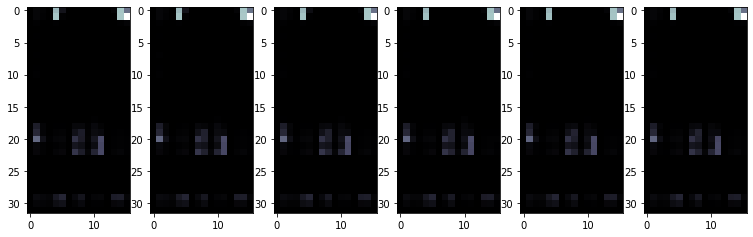

(2236, 45, 32, 16)


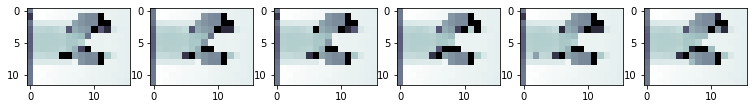

In [31]:
print(X_pm_batched_train.shape)
X_pm_batched_train = X_pm_batched_train.reshape(X_pm_batched_train.shape[0],45,32,16)
X_pm_batched_test = X_pm_batched_test.reshape(X_pm_batched_test.shape[0],45,32,16)

plot_gallery(X_pm_batched_test[16], [1,2,3],32,16,1,6)
print(X_pm_batched_train.shape)
X_dc_batched_train = X_dc_batched_train.reshape(X_dc_batched_train.shape[0],45,12,16)
X_dc_batched_test = X_dc_batched_test.reshape(X_dc_batched_test.shape[0],45,12,16)

plot_gallery(X_dc_batched_test[16], [1,2,3],16,12,1,6)

In [32]:

def get_multi_modal_model():
    # https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    input_thigh = Input(shape=(X_act_batched.shape[1],))
    input_wrist = Input(shape=(X_acw_batched.shape[1],))
    input_dc = Input(shape=(X_dc_batched_train.shape[1],
                            X_dc_batched_train.shape[2],
                            X_dc_batched_train.shape[3],))
    input_pm = Input(shape=(X_pm_batched_train.shape[1],
                            X_pm_batched_train.shape[2],
                            X_pm_batched_train.shape[3],))

    # Build some layers for the thigh
    thigh = Dense(1024, activation="sigmoid")(input_thigh)
    thigh = Dense(512, activation="sigmoid")(thigh)
    thigh = Dropout(0.1)(thigh)
    thigh = Dense(256)(thigh)
    thigh = Dense(128)(thigh)
    thigh = Dropout(0.1)(thigh)
    thigh = Dense(128)(thigh)
    thigh = Model(inputs=input_thigh, outputs=thigh)

    # Build some layers for the wrist
    wrist = Dense(1024, activation="sigmoid")(input_wrist)
    wrist = Dense(512, activation="sigmoid")(wrist)
    wrist = Dropout(0.1)(wrist)
    wrist = Dense(256)(wrist)
    wrist = Dense(128)(wrist)
    wrist = Dropout(0.1)(wrist)
    wrist = Dense(128)(wrist)
    wrist = Model(inputs=input_wrist, outputs=wrist)

    # Build some layers for the depth camera
    # but this time we will use conv2D
    filt_layers = [64, 32, 16]
    dc_tens = Conv2D(filters=filt_layers[0], 
                                kernel_size=(3,3), 
                                padding='same', 
                                activation='relu',
                                data_format="channels_first",
                                input_shape=(X_dc_batched_train.shape[1],
                                             X_dc_batched_train.shape[2],
                                             X_dc_batched_train.shape[3]))(input_dc)
    dc_tens = Dropout(0.1) (dc_tens)
    dc_tens = Conv2D(filters=filt_layers[1], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(dc_tens)
    dc_tens = Dropout(0.1) (dc_tens)

    dc_tens = Conv2D(filters=filt_layers[2], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(dc_tens)
    dc_tens = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(dc_tens)
    dc_tens = Dropout(0.1) (dc_tens)
    dc_tens = Flatten()(dc_tens)
    dc_tens = Dense(512)(dc_tens)
    dc_tens = Dropout(0.3) (dc_tens)
    dc_tens = Model(inputs=input_dc, outputs=dc_tens)


    # Build some layers for the pressure mat
    pm_tens = Conv2D(filters=filt_layers[0], 
                                kernel_size=(3,3), 
                                padding='same', 
                                activation='relu',
                                data_format="channels_first",
                                input_shape=(X_pm_batched_train.shape[1],
                                             X_pm_batched_train.shape[2],
                                             X_pm_batched_train.shape[3]))(input_pm)
    pm_tens = Dropout(0.1) (pm_tens)
    pm_tens = Conv2D(filters=filt_layers[1], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(pm_tens)
    pm_tens = Dropout(0.1) (pm_tens)

    pm_tens = Conv2D(filters=filt_layers[2], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(pm_tens)
    pm_tens = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(pm_tens)
    pm_tens = Dropout(0.1) (pm_tens)
    pm_tens = Flatten()(pm_tens)
    pm_tens = Dense(512)(pm_tens)
    pm_tens = Dropout(0.3) (pm_tens)
    pm_tens = Model(inputs=input_pm, outputs=pm_tens)


    combined = concatenate([thigh.output, wrist.output, dc_tens.output, pm_tens.output])

    # Now lets run some more dense layers
    last = Dense(128, activation="tanh")(combined)
    last = Dense(64, activation="tanh")(combined)
    prediction = Dense(units=8, activation='softmax')(last)

    model = Model(inputs=[thigh.input, wrist.input, dc_tens.input, pm_tens.input], outputs=prediction)
    return model



In [26]:
from tensorflow.keras.optimizers import Adam
model = get_multi_modal_model()
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 45, 12, 16)] 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 45, 32, 16)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 12, 16)   25984       input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 32, 16)   25984       input_9[0][0]                    
____________________________________________________________________________________________

In [27]:
%%time
history = model.fit(x=[X_act_batched_train, X_acw_batched_train, X_dc_batched_train, X_pm_batched_train],
                    y=y_train, 
                    validation_data=(
                        [X_act_batched_test,
                         X_acw_batched_test,X_dc_batched_test, X_pm_batched_test], y_test),
                    epochs=900,  batch_size=10, verbose=False)

Wall time: 18min 58s


Validation: 98.92857142857143


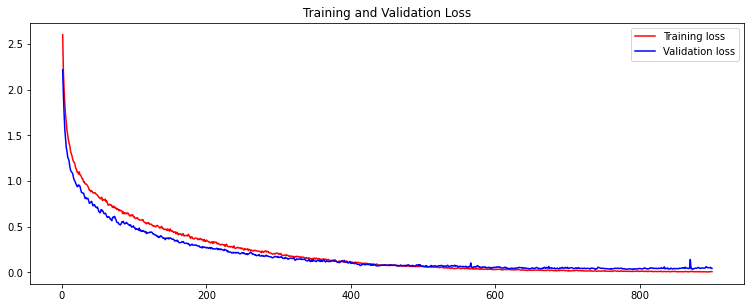

In [28]:
yhat = model.predict([X_act_batched_test, X_acw_batched_test, X_dc_batched_test, X_pm_batched_test])
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

plot_history(history)

## Let's look at our unseen subjects

In [80]:
y_unseen.shape

(209, 8)

In [33]:
X_unseen_act = df_batch_saved_off[acw_X_cols_batched].to_numpy()
X_unseen_acw = df_batch_saved_off[act_X_cols_batched].to_numpy()
X_unseen_pm = df_batch_saved_off[pm_X_cols_batched].to_numpy()
X_unseen_dc = df_batch_saved_off[dc_X_cols_batched].to_numpy()

X_unseen_pm = X_unseen_pm.reshape(X_unseen_pm.shape[0],45,32,16)
X_unseen_dc = X_unseen_dc.reshape(X_unseen_dc.shape[0],45,12,16)

yhat = model.predict([X_unseen_act, X_unseen_acw, X_unseen_dc, X_unseen_pm])
yhat = np.argmax(yhat, axis=1)
y_unseen_actual = np.argmax(y_unseen, axis=1)
print('Unseen:', accuracy_score(y_unseen_actual, yhat)*100)

Unseen: 83.25358851674642


In [42]:
print(X_act_batched.shape)
print(X_acw_batched.shape)
print(X_pm_batched.shape)
print(X.shape)

(2796, 900)
(2796, 900)
(2796, 23040)
(2796, 33480)


Fold 0
Train: 89.50882212684787
Validation: 84.69241773962804
Unseen: 67.46411483253588


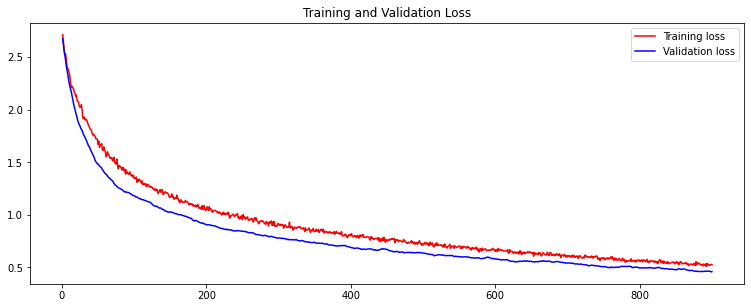

Fold 1
Train: 87.41058655221745
Validation: 83.40486409155938
Unseen: 77.51196172248804


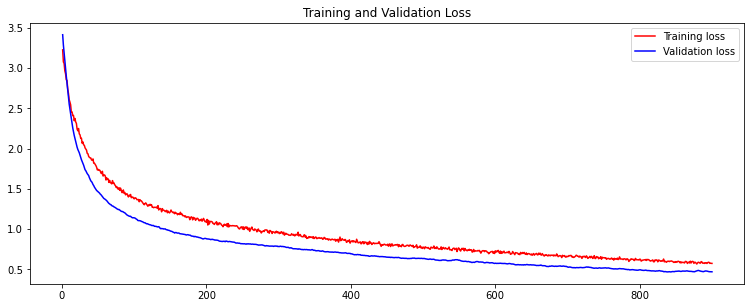

In [ ]:
%%time
folds = StratifiedKFold(n_splits=4, shuffle=True)
y_actual = np.argmax(y, axis=1)
total_model_metrics = []
for index, (train_indices, val_indices) in enumerate(folds.split(X, y_actual)):
    model = get_multi_modal_model()
    # TODO: move this to the model def.
    model.compile(optimizer=Adam(learning_rate=0.000001, beta_1=0.99, beta_2=0.999),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    X_dc_shaped_train = X_dc_batched[train_indices].reshape(X_dc_batched[train_indices].shape[0],45,12,16)
    X_pm_shaped_train = X_pm_batched[train_indices].reshape(X_pm_batched[train_indices].shape[0],45,32,16)
    
    X_dc_shaped_val = X_dc_batched[val_indices].reshape(X_dc_batched[val_indices].shape[0],45,12,16)
    X_pm_shaped_val = X_pm_batched[val_indices].reshape(X_pm_batched[val_indices].shape[0],45,32,16)
    
    history = model.fit(x=[X_act_batched[train_indices],
                           X_acw_batched[train_indices],
                           X_dc_shaped_train,
                           X_pm_shaped_train],
                    y=y[train_indices], 
                    validation_data=(
                        [X_act_batched[val_indices],
                           X_acw_batched[val_indices],
                           X_dc_shaped_val,
                           X_pm_shaped_val],
                        y[val_indices]),
                    epochs=900,  batch_size=10, verbose=False)
    
    yhat = model.predict([X_act_batched[train_indices],
                           X_acw_batched[train_indices],
                           X_dc_shaped_train,
                           X_pm_shaped_train])
    
    yhat = np.argmax(yhat, axis=1)
    y_train_actual = np.argmax(y[train_indices], axis=1)
    print(f"Fold {index}")
    print('Train:', accuracy_score(y_train_actual, yhat)*100)

    yhat = model.predict([X_act_batched[val_indices],
                           X_acw_batched[val_indices],
                           X_dc_shaped_val,
                           X_pm_shaped_val])
    yhat = np.argmax(yhat, axis=1)
    y_test_actual = np.argmax(y[val_indices], axis=1)
    print('Validation:', accuracy_score(y_test_actual, yhat)*100)
    
    
    yhat = model.predict([X_unseen_act, X_unseen_acw, X_unseen_dc, X_unseen_pm])
    yhat = np.argmax(yhat, axis=1)
    y_unseen_actual = np.argmax(y_unseen, axis=1)
    print('Unseen:', accuracy_score(y_unseen_actual, yhat)*100)
    
    plot_history(history)